# **SIFT Detector**

Number of matches: 2140
Score: 38.132573057733424
Matches found: Yes


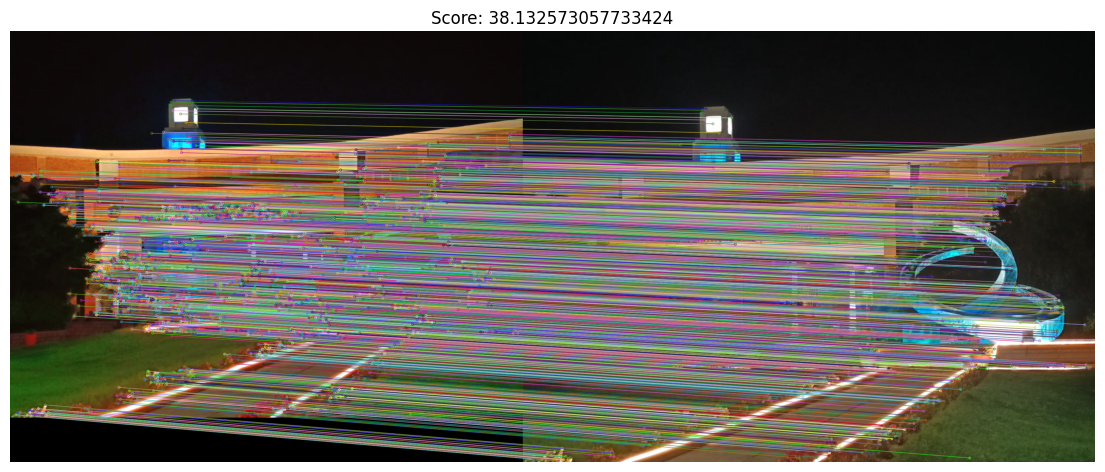

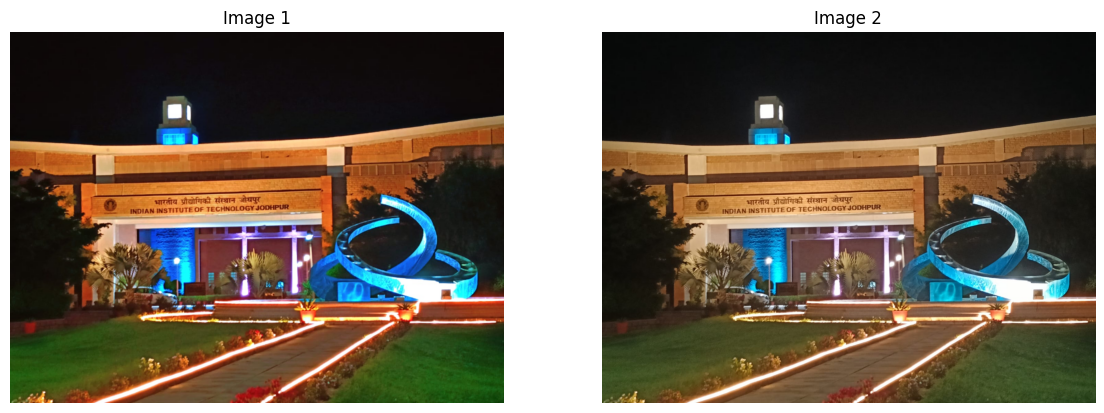

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def calculate_matches(image1_path, image2_path, score_threshold=1.0):
    try:
        # Load images
        image1 = cv2.imread(image1_path)
        image2 = cv2.imread(image2_path)

        # Convert images to grayscale
        gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

        # Initialize SIFT detector
        sift = cv2.SIFT_create()

        # Find keypoints and descriptors
        keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
        keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

        # Create FLANN matcher
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        # Match descriptors
        matches = flann.knnMatch(descriptors1, descriptors2, k=2)

        # Lowe's ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)

        # RANSAC
        if len(good_matches) > 10:
            src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            mask = mask.ravel()

            # Apply mask
            inlier_matches = [good_matches[i] for i in range(len(good_matches)) if mask[i]]

            # Calculate score
            score = len(inlier_matches) / max(len(keypoints1), len(keypoints2)) * 100

            # Check if score exceeds threshold
            if score >= score_threshold:
                # Draw matches
                img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, inlier_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

                # Display number of matches and score
                print("Number of matches:", len(inlier_matches))
                print("Score:", score)
                print("Matches found:", "Yes")

                # Display image with matches
                plt.figure(figsize=(14, 7))
                plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.title(f'Score: {score}')
                plt.show()

                # Display images
                plt.figure(figsize=(14, 7))
                plt.subplot(1, 2, 1)
                plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
                plt.title('Image 1')
                plt.axis('off')
                plt.subplot(1, 2, 2)
                plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
                plt.title('Image 2')
                plt.axis('off')
                plt.show()
            else:
                print("Score below threshold. Images may not match.")
                print("Score:", score)
                print("Matches found:", "No")
        else:
            print("Insufficient good matches to calculate homography. Images may not match.")
            print("Score: N/A")
            print("Matches found:", "No")
    except Exception as e:
        print("An error occurred:", e)

# Example usage
image1_path = "/content/image1.jpg"
image2_path = "/content/image2.jpg"
calculate_matches(image1_path, image2_path, score_threshold=20.0)


**Key-points**

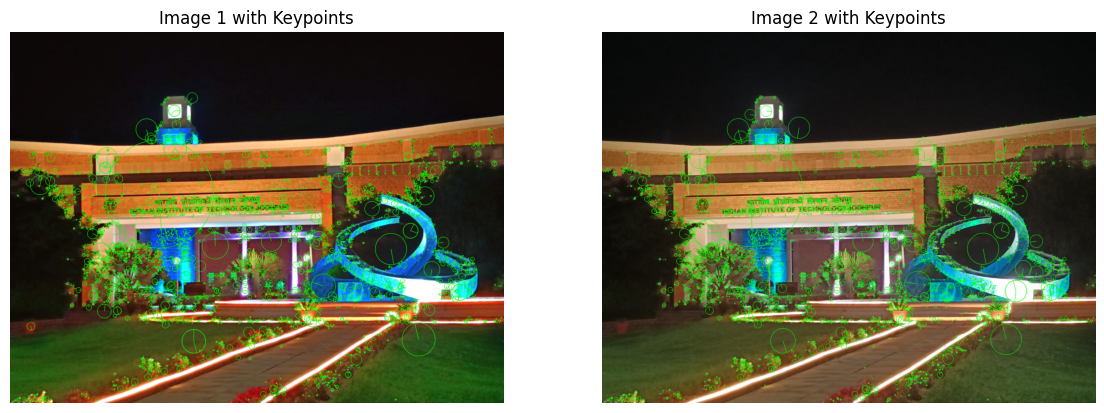

In [ ]:
# Draw keypoints on the original images with increased size and thickness
img1_keypoints = cv2.drawKeypoints(image1, keypoints1, None, color=(0, 255, 0),
                                    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_keypoints = cv2.drawKeypoints(image2, keypoints2, None, color=(0, 255, 0),
                                    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display images with keypoints
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Image 1 with Keypoints')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Image 2 with Keypoints')
plt.axis('off')
plt.show()


# **BRIEF Descriptor, Working for only few images**

Number of matches: 355
Score: 10.280915146249638
Matches found: Yes
Scale X: 0.7528612050059699
Scale Y: 0.7516004247663126
Rotation Angle (degrees): 0.02547769323005312


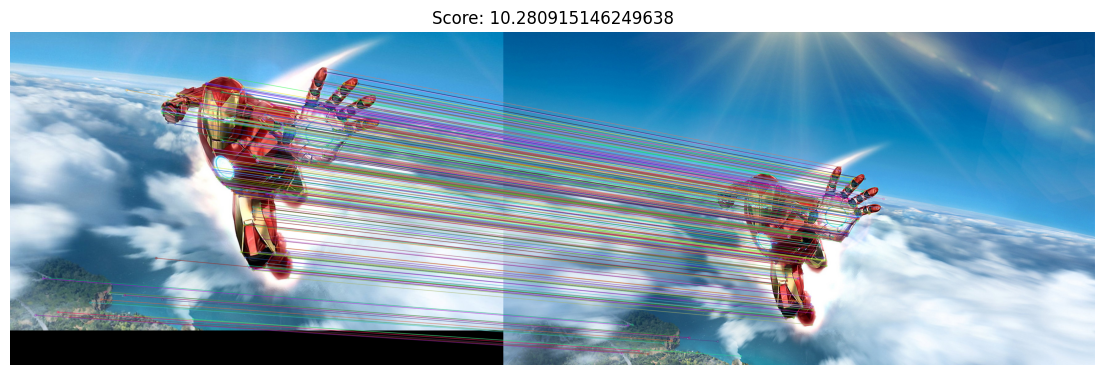

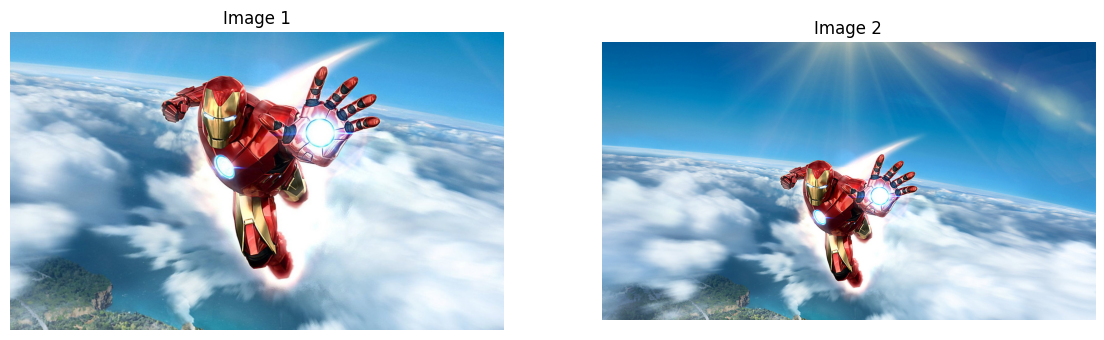

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def calculate_matches(image1_path, image2_path, score_threshold=20.0):
    try:
        # Load images
        image1 = cv2.imread(image1_path)
        image2 = cv2.imread(image2_path)

        # Check if images are loaded correctly
        if image1 is None or image2 is None:
            print("Error: One or both images could not be loaded.")
            return

        # Convert images to grayscale
        gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

        # Initialize FAST detector with parameters
        fast = cv2.FastFeatureDetector_create(threshold=20, nonmaxSuppression=True)

        # Detect keypoints
        keypoints1 = fast.detect(gray1, None)
        keypoints2 = fast.detect(gray2, None)

        # Initialize BRIEF descriptor extractor
        brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

        # Compute descriptors
        keypoints1, descriptors1 = brief.compute(gray1, keypoints1)
        keypoints2, descriptors2 = brief.compute(gray2, keypoints2)

        # Check if descriptors were found
        if descriptors1 is None or descriptors2 is None:
            print("Error: Descriptors not found in one or both images.")
            return

        # Create BFMatcher with Hamming distance metric
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

        # Match descriptors
        matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

        # Lowe's ratio test
        good_matches = []
        for match in matches:
            if len(match) == 2:
                m, n = match
                if m.distance < 0.7 * n.distance:
                    good_matches.append(m)

        # Check if there are enough good matches
        if len(good_matches) > 5:
            # Extract matched points
            src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

            # Calculate homography using RANSAC
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # Check if homography was calculated successfully
            if M is None:
                print("Error: Homography could not be calculated.")
                return

            # Apply mask to get inlier matches
            mask = mask.ravel()
            inlier_matches = [good_matches[i] for i in range(len(good_matches)) if mask[i]]

            # Calculate score as a percentage of inlier matches
            score = len(inlier_matches) / max(len(keypoints1), len(keypoints2)) * 100

            # Check if score exceeds the threshold
            if score >= score_threshold:
                # Draw matches
                img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, inlier_matches, None,
                                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

                # Display matches, score, and images
                print("Number of matches:", len(inlier_matches))
                print("Score:", score)
                print("Matches found:", "Yes")

                # Calculate and report scale and rotation difference
                # Decompose the homography matrix to extract scale and rotation
                scale_x = np.sqrt(M[0, 0] ** 2 + M[0, 1] ** 2)
                scale_y = np.sqrt(M[1, 0] ** 2 + M[1, 1] ** 2)
                rotation_angle = np.arctan2(M[1, 0], M[0, 0]) * 180 / np.pi

                print("Scale X:", scale_x)
                print("Scale Y:", scale_y)
                print("Rotation Angle (degrees):", rotation_angle)

                # Display matches and images
                plt.figure(figsize=(14, 7))
                plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.title(f'Score: {score}')
                plt.show()

                plt.figure(figsize=(14, 7))
                plt.subplot(1, 2, 1)
                plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
                plt.title('Image 1')
                plt.axis('off')
                plt.subplot(1, 2, 2)
                plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
                plt.title('Image 2')
                plt.axis('off')
                plt.show()
            else:
                print("Score below threshold. Images may not match.")
                print("Score:", score)
                print("Matches found:", "No")
        else:
            print("Insufficient good matches to calculate homography. Images may not match.")
            print("Matches found:", "No")

    except cv2.error as e:
        print("OpenCV error occurred:", e)
    except Exception as e:
        print("An unexpected error occurred:", e)


image1_path = "/content/ironman1.jpg"
image2_path = "/content/ironman2.jpg"
calculate_matches(image1_path, image2_path, score_threshold=10.0)


# **ORB Detector**

Number of matches: 165
Score: 33.0
Matches found: Yes


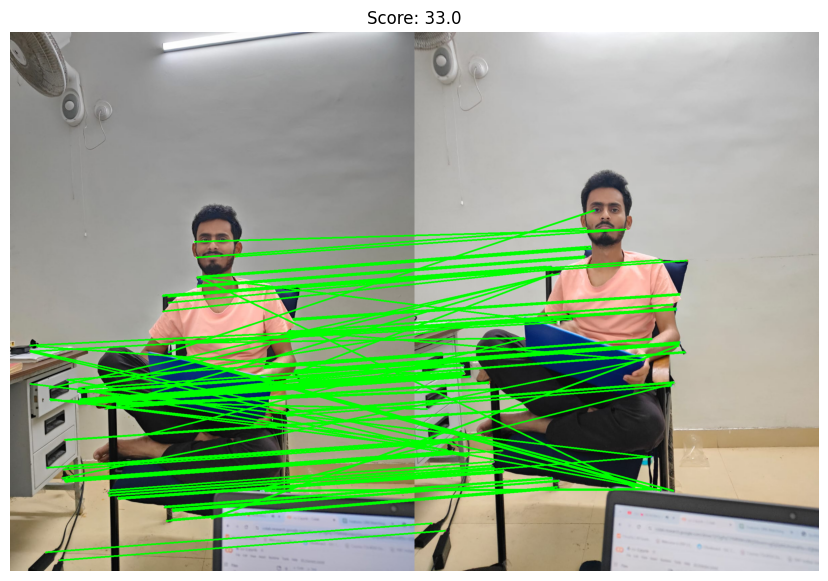

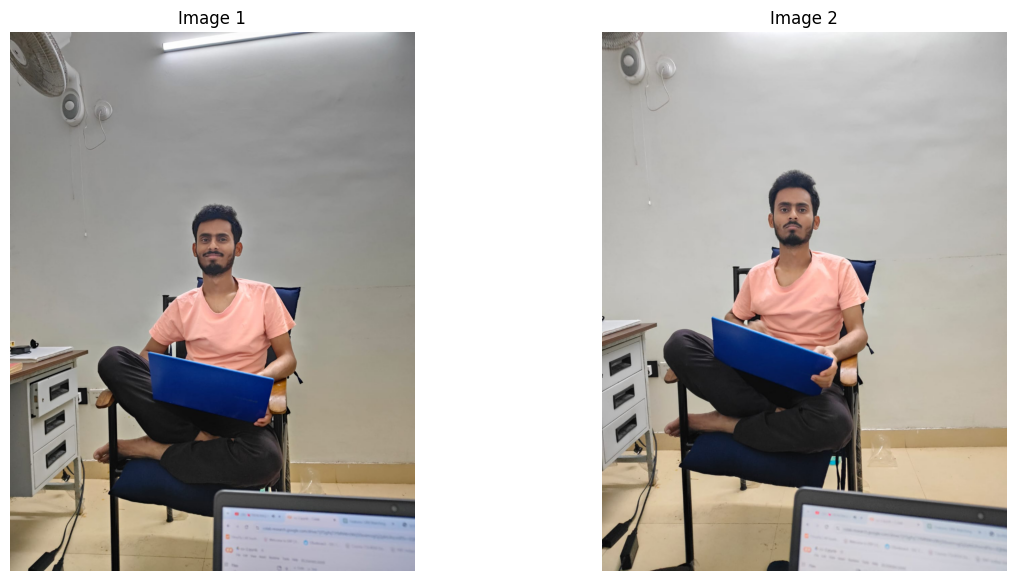

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def calculate_matches(image1_path, image2_path, score_threshold=20.0):
    try:
        # Load images
        image1 = cv2.imread(image1_path)
        image2 = cv2.imread(image2_path)

        # Convert images to grayscale
        gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

        # Initialize ORB detector
        orb = cv2.ORB_create()

        # Find keypoints and descriptors
        keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
        keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)

        # Create BFMatcher object
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

        # Match descriptors
        matches = bf.match(descriptors1, descriptors2)

        # Sort them in the order of their distance
        matches = sorted(matches, key=lambda x: x.distance)

        # Calculate score
        score = len(matches) / max(len(keypoints1), len(keypoints2)) * 100

        # Check if score exceeds threshold
        if score >= score_threshold:
            # Draw matches
            img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

            # Draw lines between matched keypoints
            for match in matches:
                # Get the matching keypoints for each of the images
                img1_idx = match.queryIdx
                img2_idx = match.trainIdx

                # x - columns, y - rows
                # Draw a small circle at both the matched keypoints
                (x1, y1) = keypoints1[img1_idx].pt
                (x2, y2) = keypoints2[img2_idx].pt

                # Draw a line between the matched keypoints
                cv2.line(img_matches, (int(x1), int(y1)), (int(x2) + image1.shape[1], int(y2)), (0, 255, 0), 3)

            # Display number of matches and score
            print("Number of matches:", len(matches))
            print("Score:", score)
            print("Matches found:", "Yes")

            # Display image with matches
            plt.figure(figsize=(14, 7))
            plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f'Score: {score}')
            plt.show()

            # Display images
            plt.figure(figsize=(14, 7))
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
            plt.title('Image 1')
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
            plt.title('Image 2')
            plt.axis('off')
            plt.show()
        else:
            print("Score below threshold. Images may not match.")
            print("Score:", score)
            print("Matches found:", "No")
    except Exception as e:
        print("An error occurred:", e)

# Example usage
image1_path = "/content/abhishek.jpg"
image2_path = "/content/abhishek3.jpg"
calculate_matches(image1_path, image2_path, score_threshold=20.0)


# **Object Localization**

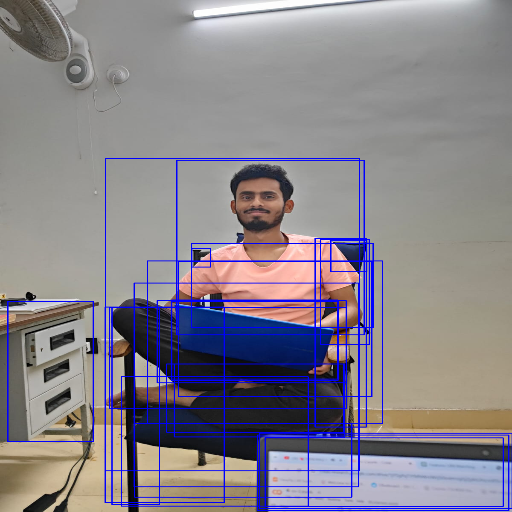

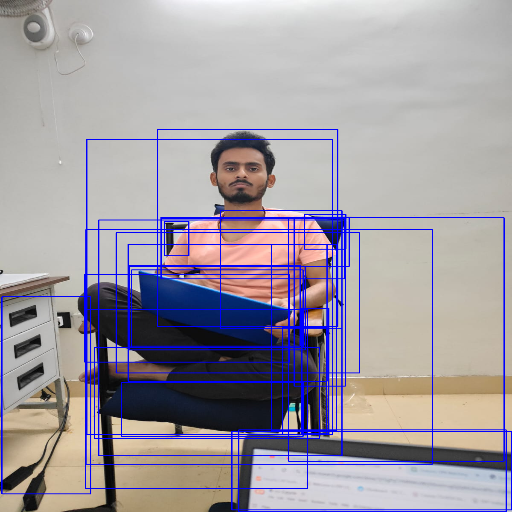

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import torch
from torchvision import models, transforms

def draw_boxes(image, boxes):
    # Draw bounding boxes on the image
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 2)
    return image

def sift_feature_matching(image1, image2):
    # Load images
    img1 = cv2.imread(image1)
    img2 = cv2.imread(image2)

    # Load pre-trained object detection model
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()

    # Preprocess images
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),  # Resize images to a fixed size
        transforms.ToTensor(),
    ])

    # Detect objects in image 1
    img1_tensor = preprocess(img1).unsqueeze(0)
    with torch.no_grad():
        prediction1 = model(img1_tensor)

    # Scale bounding boxes to original image size for image 1
    img_height1, img_width1, _ = img1.shape
    for box in prediction1[0]['boxes']:
        box[0] *= img_width1 / 256
        box[1] *= img_height1 / 256
        box[2] *= img_width1 / 256
        box[3] *= img_height1 / 256

    # Draw bounding boxes on image 1
    img1_with_boxes = draw_boxes(img1.copy(), prediction1[0]['boxes'])

    # Detect objects in image 2
    img2_tensor = preprocess(img2).unsqueeze(0)
    with torch.no_grad():
        prediction2 = model(img2_tensor)

    # Scale bounding boxes to original image size for image 2
    img_height2, img_width2, _ = img2.shape
    for box in prediction2[0]['boxes']:
        box[0] *= img_width2 / 256
        box[1] *= img_height2 / 256
        box[2] *= img_width2 / 256
        box[3] *= img_height2 / 256

    # Draw bounding boxes on image 2
    img2_with_boxes = draw_boxes(img2.copy(), prediction2[0]['boxes'])

    # Resize images for output
    img1_with_boxes_resized = cv2.resize(img1_with_boxes, (512, 512))
    img2_with_boxes_resized = cv2.resize(img2_with_boxes, (512, 512))

    # Display resized images with bounding boxes
    cv2_imshow(img1_with_boxes_resized)
    cv2_imshow(img2_with_boxes_resized)

if __name__ == "__main__":
    # Set file paths for images
    image1_path = "/content/abhishek.jpg"
    image2_path = "/content/abhishek3.jpg"

    # Perform object detection and display images with bounding boxes
    sift_feature_matching(image1_path, image2_path)
